Import all the necessary libraries

In [2]:
import numpy as np
import pandas as pd

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# The classifiers we will use in this notebook
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


# Framing the problem

In this project, we will be exploring different performance metrics for classification models. 

The dataset here is the famous MINST data for classifying different images into their corresponding digit.

The task is to take an image of a handwritten single digit, and determine what that digit is.

We will take a look at accuracy, confusion metric, precision, recall and F1 score.

# Getting the data

We will use the sklearn dataset (`fetch_openml` function) to load the data.

In [3]:
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=True, parser='auto')

# Exploratory Data Analysis

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Now let us take a look at our data.

In [5]:
X.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9   
0       0       0       0       0       0       0       0       0       0  \
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780   
0        0  ...         0         0         0         0         0         0  \
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0         0         0         0   
3        0  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 784 columns]

In [6]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

To start with, as we can see, our feature set consists of 70,000 rows and 784 columns.

Each column represents a single pixel on a 28 by 28 image frame.

The value of each column on a given sample is the "degree of blackness/whiteness" of the pixel, a value from 0 to 256.

Our target is simply the label that the corresponding row represents.

Let us visualize this below. To display our features, we will need to reshape the row and render it in image form.

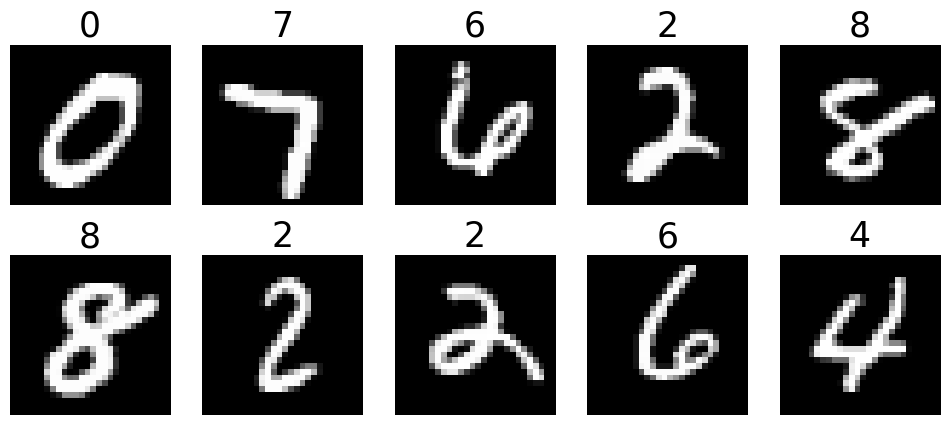

In [98]:
fig , axes  = plt.subplots(2, 5, figsize=(12,5))
axes   = axes.flatten()
idx = np.random.randint(0, 42000, size=10)
for i in range(10):
    axes[i].imshow(X[idx[i], :].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y[idx[i]])), color='black', fontsize=25)
plt.show()


We can also view the digits in a different form.

In [7]:
def visualize_input(i, ax, y):
    img = X.iloc[i].to_numpy().reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit no : {y[i]}")
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')
    ax.set_xticks([])
    ax.set_yticks([])



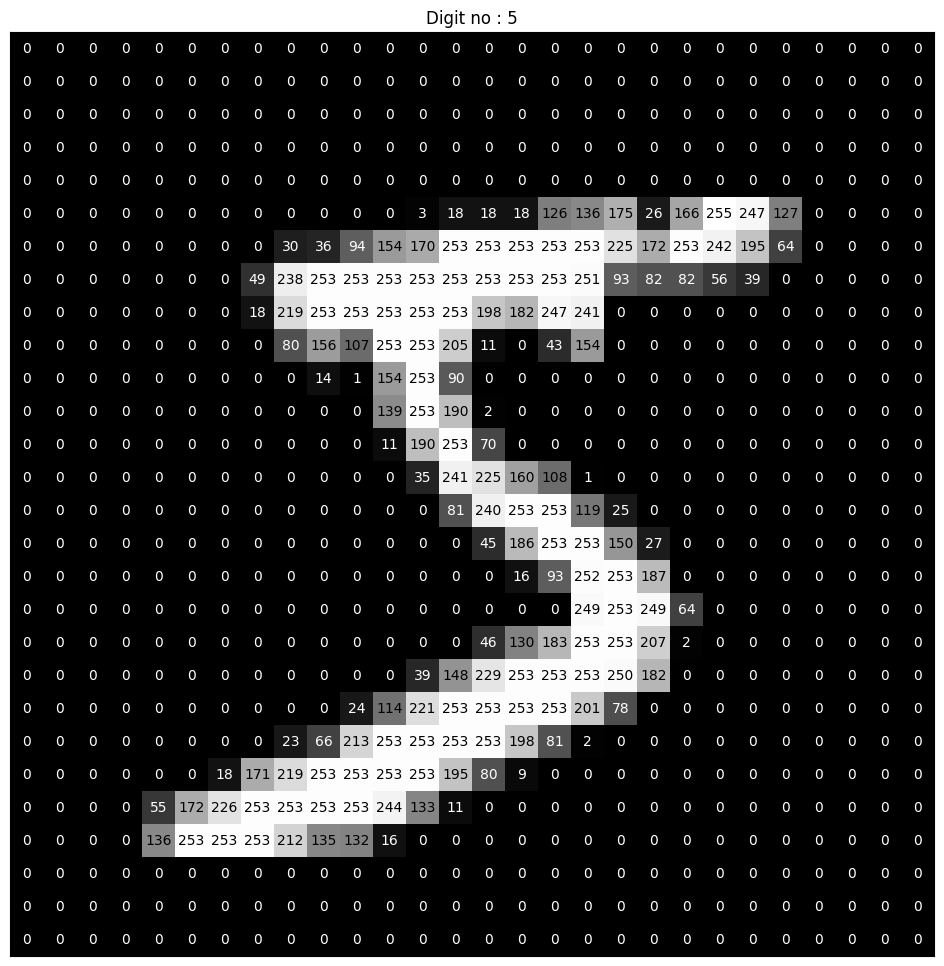

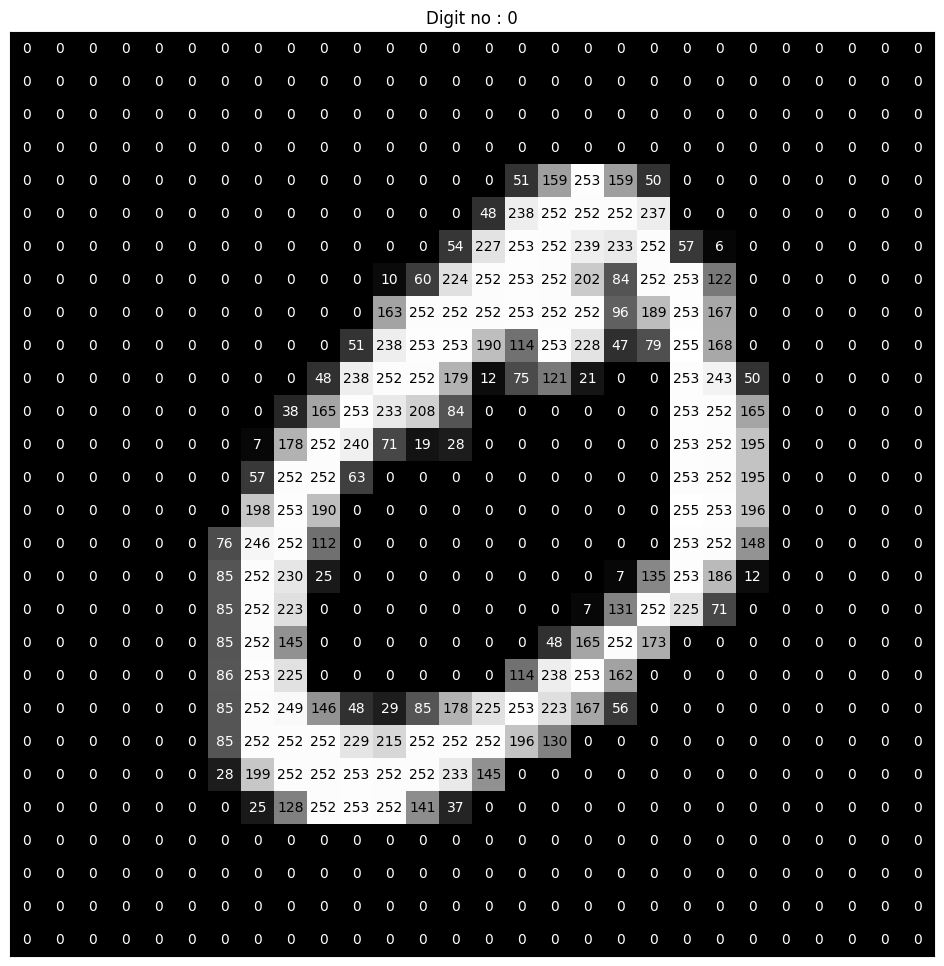

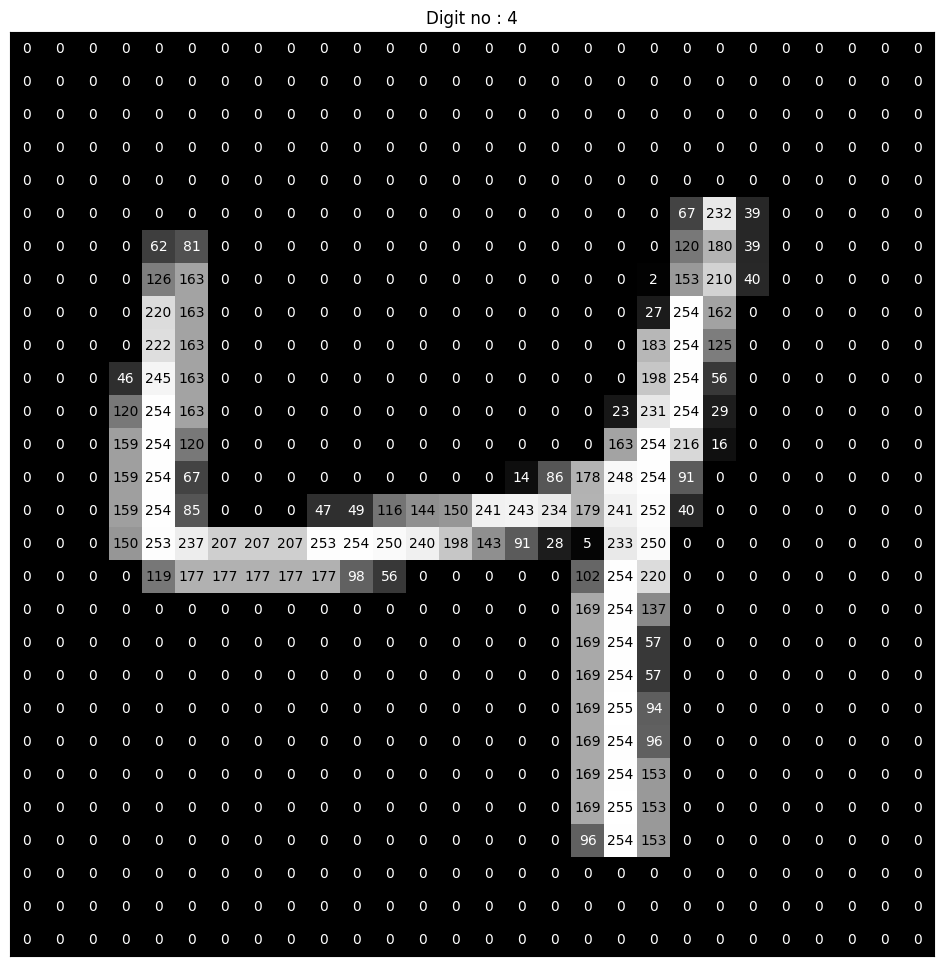

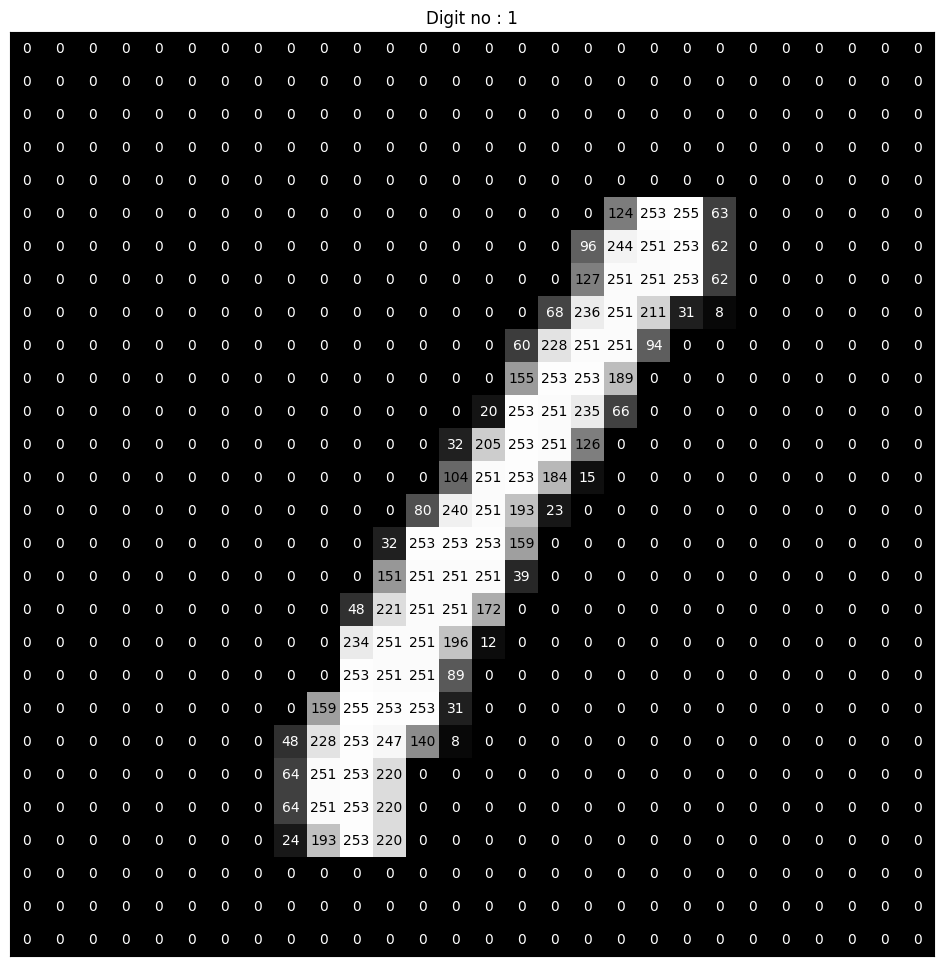

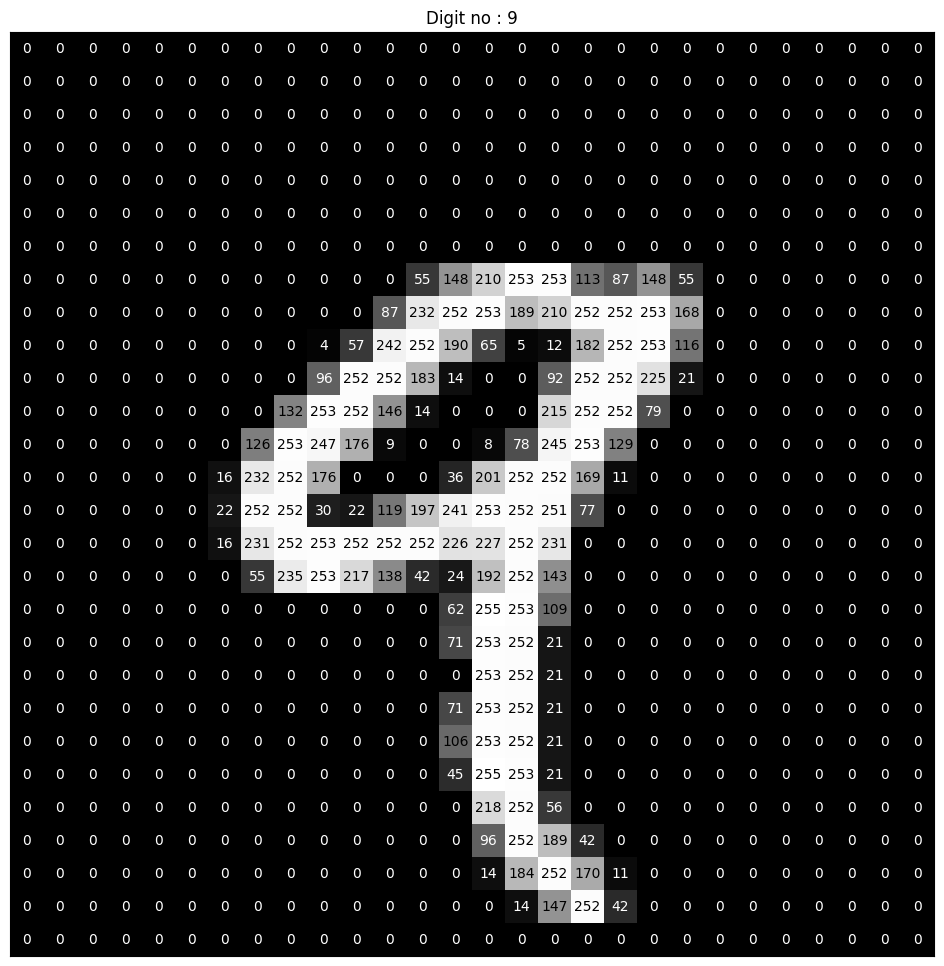

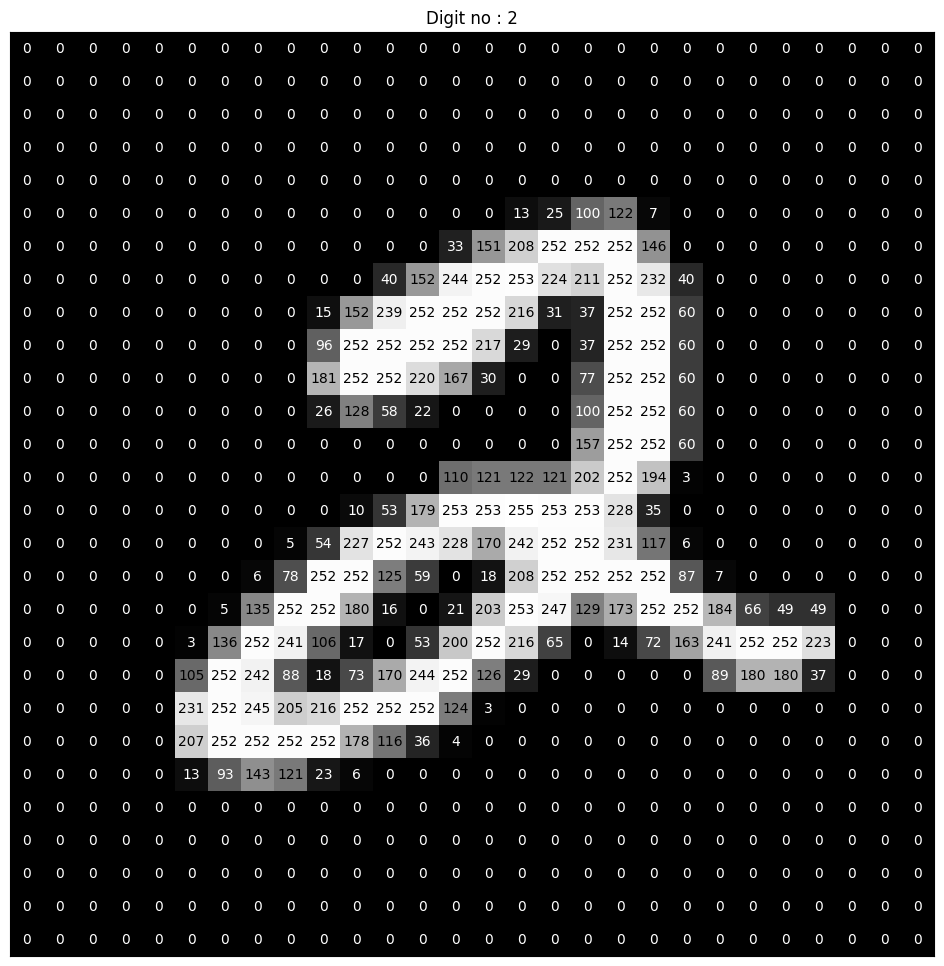

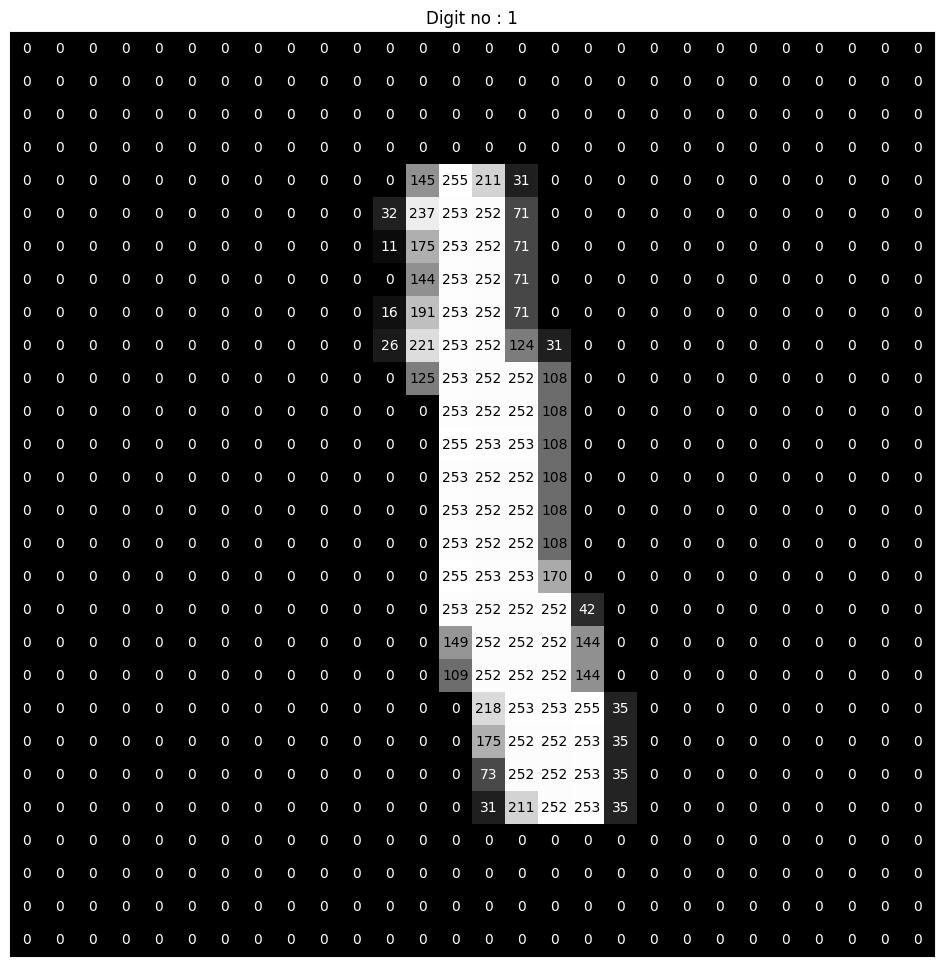

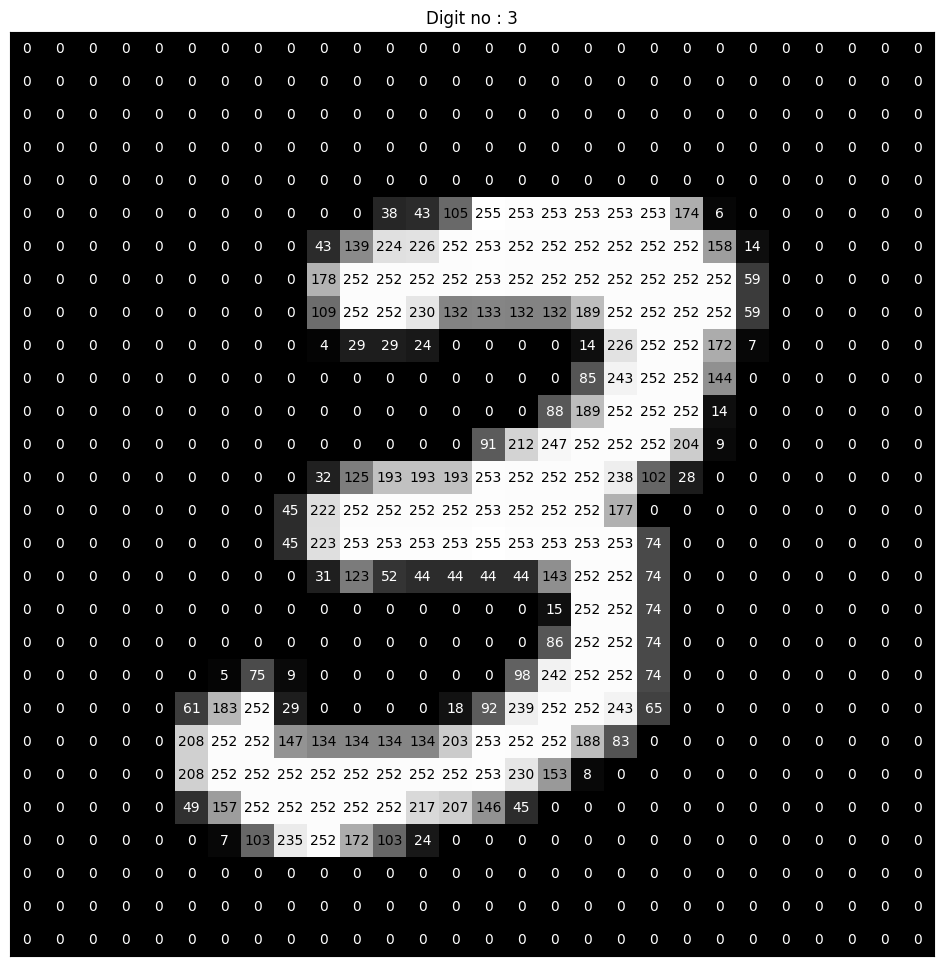

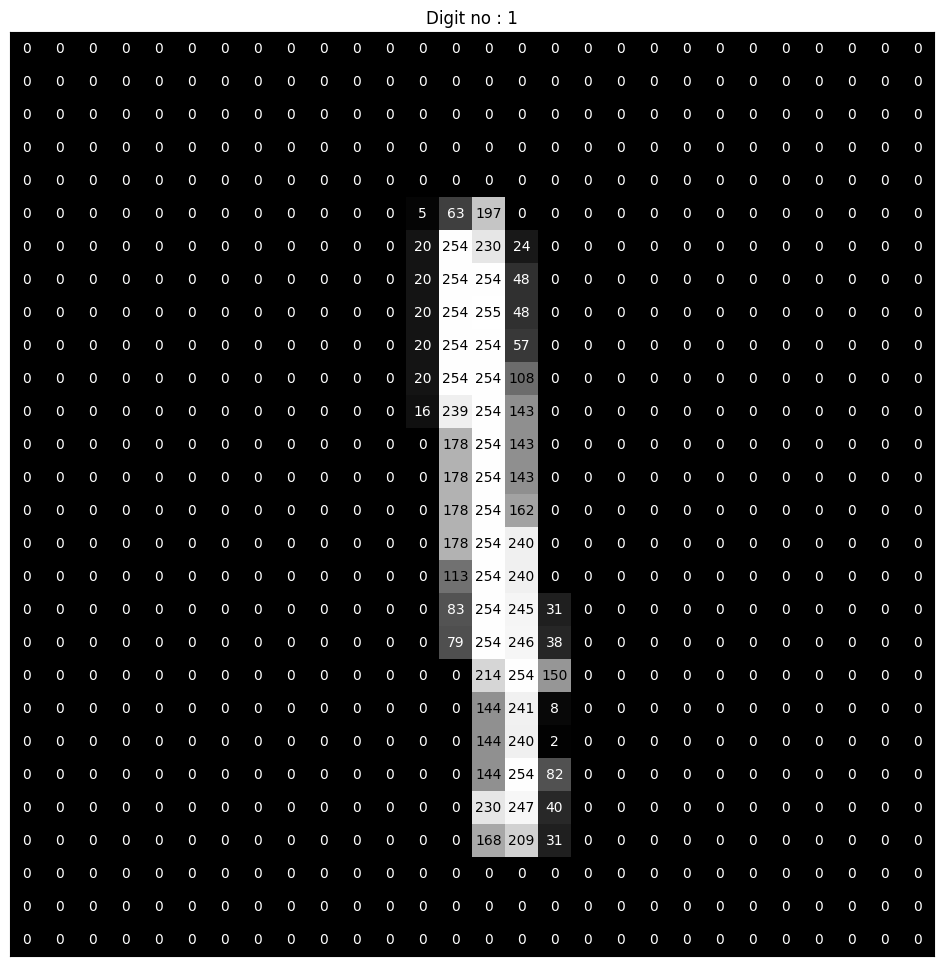

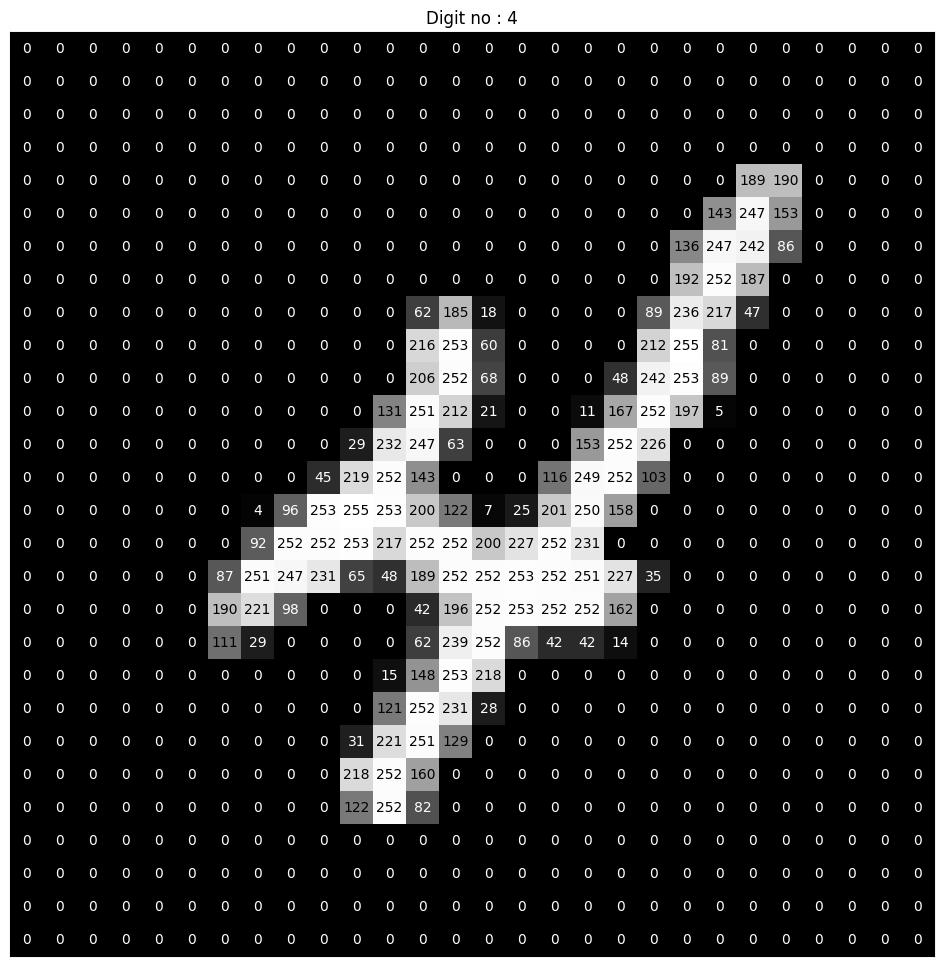

In [8]:
for i in range(10):
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    visualize_input(i, ax, y)
    
    

In [9]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [102]:
y.describe()

count     70000
unique       10
top           1
freq       7877
Name: class, dtype: object

This is the distribution of each digit in our dataset.

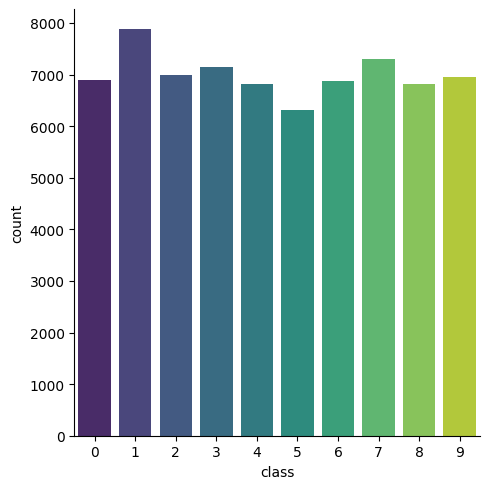

In [10]:
#use a catplot to visualize the distribution of the digits
sns.catplot(x='class', kind='count', data=y.to_frame(), palette='viridis')

# Data Preprocessing

To clean up our data, we check if we have any rows with a missing or null value or any outliers that could skew our data.

In [11]:
X.isnull().sum()

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 784, dtype: int64

In [12]:
y.isnull().sum()

0

All our rows are intact in the features so we are good to go.

We need to reshape our rows to the format we need for our model.

In [13]:
X = X.values.reshape(-1,28,28,1)/255.0

# Splitting the Data

Splitting the data into training, validation and test sets, using 70%, 15% and 15% respectively.

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We need to encode our target values.

In [15]:
y_train_encoded = to_categorical(y_train, num_classes=10)
y_valid_encoded = to_categorical(y_valid, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

In [16]:
print(X_train.shape, X_valid.shape, X_test.shape)

(56000, 28, 28, 1) (7000, 28, 28, 1) (7000, 28, 28, 1)


# Modeling

We will be using a Convolutional Neural Network (CNN) model with TensorFlow and Keras for our modeling. 

Inspiration gotten from https://www.kaggle.com/code/danielpopov/digitrecognizer-with-cnn-tensorflow

https://www.kaggle.com/code/raghaw/mnist-cnn-external-data-perfect-score

importing the tensor libraries

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau

In [18]:
model = models.Sequential([
    
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)),
    layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
    layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu'),
    layers.MaxPool2D(pool_size=2),

    layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu'),
    layers.Conv2D(filters=192, kernel_size=3, padding='same',activation='relu'),
    layers.MaxPool2D(pool_size=2),
    
    layers.Conv2D(filters=192, kernel_size=5, padding='same',activation='relu'),
    layers.MaxPool2D(pool_size=2, padding='same'),
    
    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax'),
])
    

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 192)       221376    
                                                        

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

history = model.fit(
    X_train, y_train_encoded, 
    epochs=1,
    validation_split=0.1, 
    callbacks=[reduce_lr],
)

   4/1575 [..............................] - ETA: 4:50 - loss: 2.3064 - accuracy: 0.0547

1575/1575 [==============================] - 293s 185ms/step - loss: 0.1178 - accuracy: 0.9626 - val_loss: 0.0768 - val_accuracy: 0.9761 - lr: 0.0010


Some things to point out in the model fitting:

A Sequential model is created with several convolutional layers (Conv2D), max pooling layers (MaxPool2D), a flatten layer to convert the 2D outputs to 1D, and two dense (fully connected) layers. The final layer uses a softmax activation function to output probabilities for each of the 10 classes.

The model is compiled with the Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and accuracy as the metric to monitor.

ReduceLROnPlateau is set up to reduce the learning rate by a factor of 0.3 if the loss does not decrease for 2 epochs. The minimum learning rate is set to 1e-8.

The model is trained for any number of epochs, with 10% of the training data used as a validation set. The learning rate reduction strategy is used as a callback during training.

- An epoch is one complete pass through the entire training dataset. The number of epochs is a hyperparameter that defines the number of times the learning algorithm will work through the entire training dataset. If you put 1 or 2, the model will only pass through the entire dataset 1 or 2 times, which may not be enough for it to learn effectively. However, too many epochs can lead to overfitting. The choice of the number of epochs is usually made based on validation performance.


I chose a low epoch because:

it takes about 5 minutes to complete one epoch, depending on your computer's processing power, it could take longer.

I don't want a "perfect" model, I want the model to fail in some instances in its prediction so we can see how it affects our precision and recall scores. 

# Evaluation

In [22]:
# Make predictions on the validation set
y_valid_pred = model.predict(X_valid)

  9/219 [>.............................] - ETA: 8s

219/219 [==============================] - 10s 46ms/step


In [23]:
# Get the maximum predicted probability for each sample
max_probs = np.max(y_valid_pred, axis=1)

# Convert the model's probability outputs to class labels
y_valid_pred_labels = np.argmax(y_valid_pred, axis=1)

# Create a DataFrame
df = pd.DataFrame({
    'Probability of predicting the predicted digit': max_probs,
    'Actual prediction by the model': y_valid_pred_labels,
    'Ground truth': y_valid
})

# Display the DataFrame
display(df)

Probability of predicting the predicted digit   
49935                                       0.998981  \
63854                                       0.999942   
2549                                        0.999425   
56672                                       0.938676   
26698                                       0.989757   
...                                              ...   
3416                                        0.997485   
21093                                       0.998060   
53262                                       0.999990   
30166                                       0.999985   
13399                                       0.901378   

       Actual prediction by the model Ground truth  
49935                               5            5  
63854                               7            7  
2549                                5            5  
56672                               8            8  
26698                               1            1  
...                               ...          ...  
3416                                5            5  
21093                               5            5  
53262                               3            3  
30166                               7            7  
13399                               1            1  

[7000 rows x 3 columns]

In [24]:
y_valid_pred_labels = y_valid_pred_labels.astype(str)
y_valid_pred_labels = pd.Series(y_valid_pred_labels).astype('category')

## Accuracy

In [25]:
accuracy = accuracy_score(y_valid, y_valid_pred_labels)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9774285714285714


## Confusion Matrix

In [26]:
conf_mat = confusion_matrix(y_valid, y_valid_pred_labels)
print(f'Confusion matrix:\n {conf_mat}')

Confusion matrix:
 [[639   0   1   2   0   4   4   1   1   6]
 [  0 765   0   1   4   2   6   2   0   0]
 [  0   0 641  11   0   0   0   9   1   2]
 [  0   0   0 716   0   0   0   1   0   1]
 [  0   0   1   0 620   0   0   0   0  15]
 [  0   0   0   3   0 635   0   0   1   0]
 [  2   0   1   0   3  27 673   0   1   0]
 [  0   0   2   3   1   0   0 782   0   5]
 [  0   1   1   5   1   3   1   2 694   6]
 [  0   0   0   8   3   1   0   1   1 677]]


## Precision, Recall and F1

In [95]:
report_df = pd.DataFrame(classification_report(y_valid, y_valid_pred_labels, output_dict=True)).T   
display(report_df)

precision    recall  f1-score      support
0              0.996880  0.971125  0.983834   658.000000
1              0.998695  0.980769  0.989651   780.000000
2              0.990726  0.965361  0.977879   664.000000
3              0.955941  0.997214  0.976142   718.000000
4              0.981013  0.974843  0.977918   636.000000
5              0.944940  0.993740  0.968726   639.000000
6              0.983918  0.951909  0.967649   707.000000
7              0.979950  0.986129  0.983030   793.000000
8              0.992847  0.971989  0.982307   714.000000
9              0.950843  0.979740  0.965075   691.000000
accuracy       0.977429  0.977429  0.977429     0.977429
macro avg      0.977575  0.977282  0.977221  7000.000000
weighted avg   0.977933  0.977429  0.977478  7000.000000

## Precision Recall Curve

We will use class 9 because it has both a "low" preciosn and recall compared to the other classes in our dataset.

In [59]:
# Get the predicted probabilities for the class '9'
y_scores = y_valid_pred[:, 9]

y_valid_is_9 = (y_valid == '9')

In [60]:
precisions, recalls, thresholds = precision_recall_curve(y_valid_is_9, y_scores)


In [73]:
threshold = 0.7

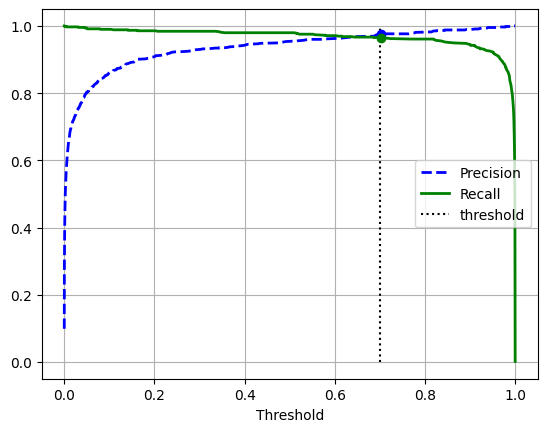

In [76]:
# Plot precision-recall curve
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)


plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")


plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.grid(True)
plt.show()

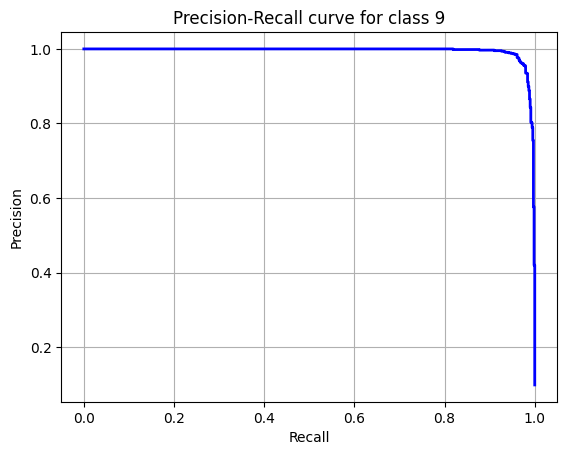

In [80]:
# Plot precision vs recall
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.title('Precision-Recall curve for class 9')
plt.show()

## Insights and Observations

First thing that strikes me is that this is a very good model, compared to other models that we could have used.

An accuracy of 97.7% on our validation set over 10 classes is *pretty good.

From the confusion matrix we can see the false positives and false negatives. We can also see out true positives across the diagonals.

Now looking at the precision and recall scores over each class, we can notice that:
class 1 has the highest precision, I guess it's easy to predict a digit of 1.

We can also see that digit class 3 has the highest recall score.

Class 9 has a low precision and recall, I guess sometimes a 9 can look like a 8 or a 7 or sometimes a 6, haha.

## Increasing Precision and Recall

Precision measures the proportion of true positive predictions out of all positive predictions made by the model.

In other words, from all the positives predicted by the model, how many were correct?

Recall measures the proportion of true positive predictions out of all actual positives in the dataset.

In other words, from all the positives in the dataset, how many did the model predict correctly?

To increase precision or recall without retraining the model, we can adjust the decision threshold. By default, the threshold is 0.5 for binary classification: probabilities above 0.5 are classified as positive, and those below are classified as negative. If we decrease the threshold, we can classify more samples as positive, which will increase recall which may decrease precision. If you increase the threshold, we'll classify fewer samples as positive, which will increase precision but may decrease recall.

Let us see this in action.

In [99]:
high_threshold = 0.90
y_pred_high_threshold = (y_scores > high_threshold)
high_precision = precision_score(y_valid_is_9, y_pred_high_threshold)
new_recall = recall_score(y_valid_is_9, y_pred_high_threshold)
print(f'Precision with high threshold: {high_precision}')
print(f'Recall with high threshold: {new_recall}')

Precision with high threshold: 0.9893939393939394
Recall with high threshold: 0.9450072358900145


In [100]:
# Choose a lower threshold to increase recall
low_threshold = 0.3
y_pred_low_threshold = (y_scores > low_threshold)
high_recall = recall_score(y_valid_is_9, y_pred_low_threshold)
new_precision = precision_score(y_valid_is_9, y_pred_low_threshold)
print(f'Recall with low threshold: {high_recall}')
print(f'Precision with low threshold: {new_precision}')

Recall with low threshold: 0.984081041968162
Precision with low threshold: 0.9302325581395349


Looking at the above, remember that the inital precion score for class 9 was `0.950843` but now, with a high threshold, it is `0.989`. Our precision did indeed increase and the recall went down from `0.9797` to `0.945`.

Similarly, as we really lowered our threshold value, we have a higher recall score now at `0.984` from `0.979` previously. We can also see that this affected our precision. It is now `0.93` while it was `0.95`

# Conclusions

In [87]:
#predict the test set
y_test_pred = model.predict(X_test)

219/219 [==============================] - 16s 71ms/step


In [88]:
# Get the maximum predicted probability for each sample
max_probs = np.max(y_test_pred, axis=1)

# Convert the model's probability outputs to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Create a DataFrame
df = pd.DataFrame({
    'Probability of predicting the predicted digit': max_probs,
    'Actual prediction by the model': y_test_pred_labels,
    'Ground truth': y_test
})

# Display the DataFrame
display(df)

Probability of predicting the predicted digit   
10538                                       0.999756  \
4883                                        0.999994   
56618                                       0.999238   
45812                                       0.987402   
48959                                       0.995570   
...                                              ...   
508                                         0.999499   
41064                                       0.997204   
67978                                       0.998813   
39507                                       0.999566   
66219                                       0.999399   

       Actual prediction by the model Ground truth  
10538                               5            5  
4883                                3            3  
56618                               9            9  
45812                               0            0  
48959                               4            4  
...                               ...          ...  
508                                 1            1  
41064                               8            8  
67978                               7            7  
39507                               2            2  
66219                               8            8  

[7000 rows x 3 columns]

In [89]:
y_test_pred_labels = y_test_pred_labels.astype(str)
y_test_pred_labels = pd.Series(y_test_pred_labels).astype('category')

## Accuracy

In [90]:
accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9772857142857143


## Confusion Matrix

In [91]:
conf_mat = confusion_matrix(y_test, y_test_pred_labels)
print(f'Confusion matrix:\n {conf_mat}')

Confusion matrix:
 [[662   0   7   3   0   1   3   2   2   5]
 [  0 809   3   1   0   1   1   3   2   0]
 [  0   1 701   5   0   0   1   4   3   1]
 [  0   0   2 710   0   2   0   1   0   0]
 [  0   0   1   0 640   0   0   1   1  16]
 [  0   0   0   5   0 626   1   0   2   0]
 [  0   0   0   1   1  32 653   0   1   1]
 [  0   0   1   3   0   0   0 702   0   4]
 [  0   0   1   7   0   4   0   4 623   4]
 [  1   0   0   6   3   1   0   1   2 715]]


## Precision, Recall and F1

In [97]:
# Compute precision, recall, F1-score
report = classification_report(y_test, y_test_pred_labels)
report_df = pd.DataFrame(classification_report(y_test, y_test_pred_labels, output_dict=True)).T
display(report_df)

precision    recall  f1-score      support
0              0.998492  0.966423  0.982196   685.000000
1              0.998765  0.986585  0.992638   820.000000
2              0.979050  0.979050  0.979050   716.000000
3              0.958165  0.993007  0.975275   715.000000
4              0.993789  0.971168  0.982348   659.000000
5              0.938531  0.987382  0.962337   634.000000
6              0.990895  0.947750  0.968843   689.000000
7              0.977716  0.988732  0.983193   710.000000
8              0.979560  0.968896  0.974199   643.000000
9              0.958445  0.980796  0.969492   729.000000
accuracy       0.977286  0.977286  0.977286     0.977286
macro avg      0.977341  0.976979  0.976957  7000.000000
weighted avg   0.977778  0.977286  0.977335  7000.000000

Looking at the performance of the model on our test set, this is a good performance. Especially when you consider what a dummy classifier would have done in this case. The most popular class is 1, so it would have probably scored somewhere between a 10% to a 15% accuracy.

Mind you, this is with just 1 epoch, I tried it with 17 epochs and all the evaluation metrics were near perfect.

The accuracy is 97.7%, average precision across all classes is 0.9777778 and the recall is 0.977286. 

Very high accuracy, precision and recall scores.

We could have improved the scores with more epochs.